In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import cycle
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import r2_score, make_scorer
from scipy import stats
%matplotlib inline 

/Users/pasquierjb/anaconda3/envs/hrm/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Preparing Data

### Loading HH Data

In [2]:
#hh_data = pd.read_csv("../Data/Intermediate_files/hh_village_coord_fcs.csv")

In [3]:
hh_data = pd.read_csv("../Data/Intermediate_files/hh_data_2011_cluster_minHH.csv")

### Loading CNN features

In [4]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features.csv")

In [5]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms.csv")

In [6]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGG16_block4_pool.csv")

In [7]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean.csv")

In [8]:
#CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_VGGF_caffe_conv7_mean_100imagescluster.csv")

In [34]:
CNN_features = pd.read_csv("../Data/Intermediate_files/google_sat_CNN_features_lsms_Resnet50_keras_avg_pool_3imagescluster.csv")

### Merging

In [35]:
data=hh_data.merge(CNN_features,on=["i","j"])

In [36]:
data = data.sample(frac=1, random_state=1783).reset_index(drop=True) #Shuffling the data

In [37]:
start_features=len(hh_data.columns)+2

In [38]:
data_features=data.iloc[:,start_features:]

### Defining predictors and predicting variables

In [39]:
y = data["cons"].values #Average normalized consumption per cluster
y = y[y > 0]
y = np.log(y) #Log-normal distribution

In [40]:
y2 = data["poor_majority"] #Dummy variable for majority of poor in the cluster

In [41]:
X=data_features.values

In [42]:
X.shape

(309, 2048)

In [43]:
y.shape

(309,)

(array([  3.,  14.,  47.,  85.,  70.,  35.,  28.,  20.,   5.,   2.]),
 array([-0.40340905, -0.02670821,  0.34999262,  0.72669345,  1.10339428,
         1.48009511,  1.85679595,  2.23349678,  2.61019761,  2.98689844,
         3.36359927]),
 <a list of 10 Patch objects>)

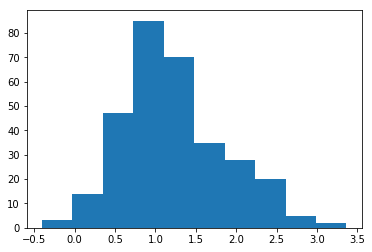

In [44]:
plt.hist(y)

In [45]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.702923,0.495396,1.025385,0.314796,0.000000,0.000000,0.000000,0.000000,0.011628,0.005166,...,0.000000,0.000000,0.000000,0.104676,0.000000,0.284090,0.063676,0.351802,0.000000,0.033764
1,0.504995,0.058308,0.664449,0.237321,0.039581,0.005937,0.049166,0.000000,1.254678,0.078812,...,0.164999,0.000000,0.000000,0.083740,0.000000,0.406295,0.065145,0.221510,0.000000,0.002794
2,0.488179,0.631900,0.806425,0.002564,0.239646,0.000000,0.180585,0.000000,0.000000,0.005430,...,0.000000,0.000493,0.033078,0.222200,0.120360,1.212169,0.016469,0.199096,0.000000,0.221078
3,0.445076,0.589066,0.868678,1.001213,0.000000,0.000000,0.000000,0.000000,0.289268,0.056454,...,0.028041,0.000000,0.000000,0.015100,0.000000,0.851187,0.758568,0.920750,0.000000,0.049915
4,0.051571,0.134008,0.104889,0.003326,0.196793,0.000000,0.033260,0.060503,0.027409,0.030667,...,0.000000,0.000000,0.000000,0.002754,0.056166,0.047015,0.000000,0.162287,0.004386,0.002144


# 2. Predicting Continuous Indicator

In [46]:
alphas = np.array([0.01,0.1,1,5,10,20,30,40,50])

In [47]:
model=Ridge()

In [48]:
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1673)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=75788)

In [49]:
def r2_pearson(ground_truth, predictions):
    r2_pearson=stats.pearsonr(ground_truth, predictions)[0] ** 2
    return r2_pearson
r2_pearson = make_scorer(r2_pearson, greater_is_better=True)

In [50]:
#Inner cross-validation loop
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=inner_cv, scoring=r2_pearson)

## From PCA Components

In [34]:
pca = PCA(n_components=10)

In [35]:
pca.fit(data_features.transpose())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
eigenvectors=pca.components_

In [37]:
X2 = pd.DataFrame(np.transpose(eigenvectors))
X2.shape

(309, 10)

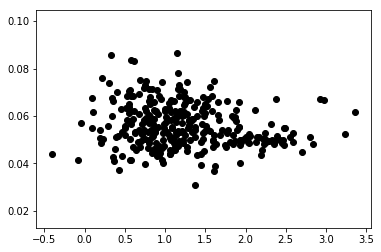

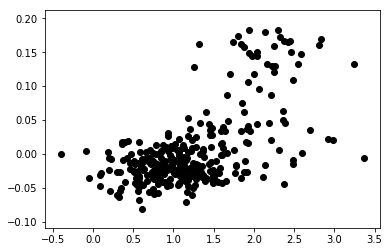

In [38]:
for i in range(2):
    plt.figure()
    plt.scatter(y, eigenvectors[i],  color='black')

In [39]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

r2 (pearson): 0.44 (+/- 0.07)


In [40]:
# Outer Loop with R2
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

R2: 0.42 (+/- 0.08)


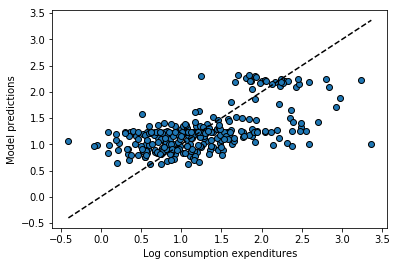

In [41]:
y_hat = cross_val_predict(clf, X2, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

## From all (4096) features

In [51]:
alphas = np.array([1,5,10,20,30,40,50])

In [52]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

r2 (pearson): 0.27 (+/- 0.08)


In [53]:
r2

array([ 0.32164875,  0.24431153,  0.29261055,  0.2027855 ,  0.26800015])

In [54]:
# Outer Loop with R2
R2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.19 (+/- 0.14)


In [55]:
R2

array([ 0.28538672,  0.19973528,  0.22829268,  0.08810981,  0.13443399])

In [56]:
neg_mean_squared_error = cross_val_score(clf, X, y, cv=outer_cv,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (-neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: 0.32 (+/- 0.11)


In [57]:
-neg_mean_squared_error

array([ 0.29554184,  0.42182293,  0.28796173,  0.34340098,  0.27132857])

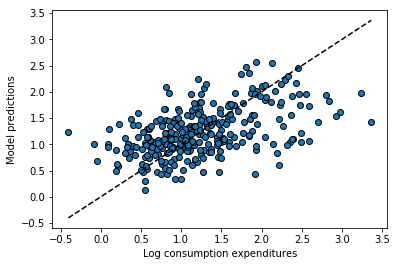

In [58]:
y_hat = cross_val_predict(clf, X, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

In [59]:
r2_score(y,y_hat)

0.20208833981996588

In [60]:
stats.pearsonr(y,y_hat)[0] ** 2

0.24859607770797726

# 3. Predicting Dummy Indicator from all features

In [52]:
model = linear_model.LogisticRegression(penalty="l2")
model.fit(X, y2) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
cv = KFold(n_splits=10, shuffle=True, random_state=167)

In [54]:
accuracy = cross_val_score(model, X, y2, cv=cv)
f1 = cross_val_score(model, X, y2, cv=cv,scoring='f1')
precision = cross_val_score(model, X, y2, cv=cv,scoring='precision')
recall= cross_val_score(model, X, y2, cv=cv,scoring='recall')
auc= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')
confusion= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')

In [55]:
scores = cross_val_score(model, X, y2, cv=10,scoring='precision')
accuracy_print=("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
f1_print=("F1: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))
precision_print=("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall_print=("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
auc_print=("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))
print(os.linesep.join([accuracy_print,f1_print,precision_print,recall_print,auc_print]))

Accuracy: 0.79 (+/- 0.12)
F1: 0.47 (+/- 0.22)
Precision: 0.68 (+/- 0.34)
Recall: 0.38 (+/- 0.25)
AUC: 0.80 (+/- 0.14)


In [56]:
y2.describe()

count    309.000000
mean       0.258900
std        0.438741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: poor_majority, dtype: float64